# End-to-End regression project

## Learning objectives

Use best practices to

* See a complete workflow on a simple dataset
* Use cross-validation to select hyperparameters
* Use cross-validation to select between models

## Metric

We will be using $R^2$ as our metric. **Before** starting the project, we should have a threshold for what score is good enough. We will always be able to spend more time engineering features, or looking for errors. Knowing what the acceptable score for business purposes helps you not chase diminishing returns.

## Dataset

We will use the NY taxi dataset we looked at earlier. To speed things up, some of the extraneous columns have been removed.

In [82]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import Nystroem

plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

In [2]:
import sklearn
sklearn.__version__

'0.20.2'

In [3]:
file_location = pathlib.Path.cwd() / 'Resources' / 'taxi_clean_reduced.csv'
taxi_df = pd.read_csv(file_location, parse_dates=['tpep_pickup_datetime'])

In [4]:
taxi_df.head()

,tpep_pickup_datetime,passenger_count,trip_distance,DOLocationID,durations_minutes
0,2018-01-01 00:19:12,2,1.13,161,15.616667
1,2018-01-01 00:58:14,1,3.00,224,17.333333
2,2018-01-01 00:28:40,1,1.10,162,4.500000
3,2018-01-01 00:59:59,1,0.93,237,5.016667
4,2018-01-01 00:25:58,1,3.40,224,20.600000


## Split the data

Because of the nature of this problem, we are _not_ going to use sklearn's built in train-test split. Instead, we are going to make a split in time.

In [5]:
train_mask = (taxi_df['tpep_pickup_datetime'] < '2018-01-24')

X_train = taxi_df[train_mask].drop('durations_minutes', axis=1)
X_test = taxi_df[~train_mask].drop('durations_minutes', axis=1)

y_train = taxi_df.loc[train_mask, 'durations_minutes']
y_test = taxi_df.loc[~train_mask, 'durations_minutes']

In [6]:
X_train.shape, X_test.shape

((255050, 4), (105935, 4))

## Do EDA on the training data

An even more disciplined way to do this is to take a small sample of your data and use it for EDA, then throw it away (i.e. don't train on it). This is because your insights from your EDA may end up using rows that are in the validation set.

In practice, this isn't a huge issue, and you are generally fine skipping this split.

In [7]:
# We are going to subsample for the purposes of plotting
# but we skip the "best practice" of throwing the data away
explore = taxi_df[train_mask].sample(10000, random_state=42)

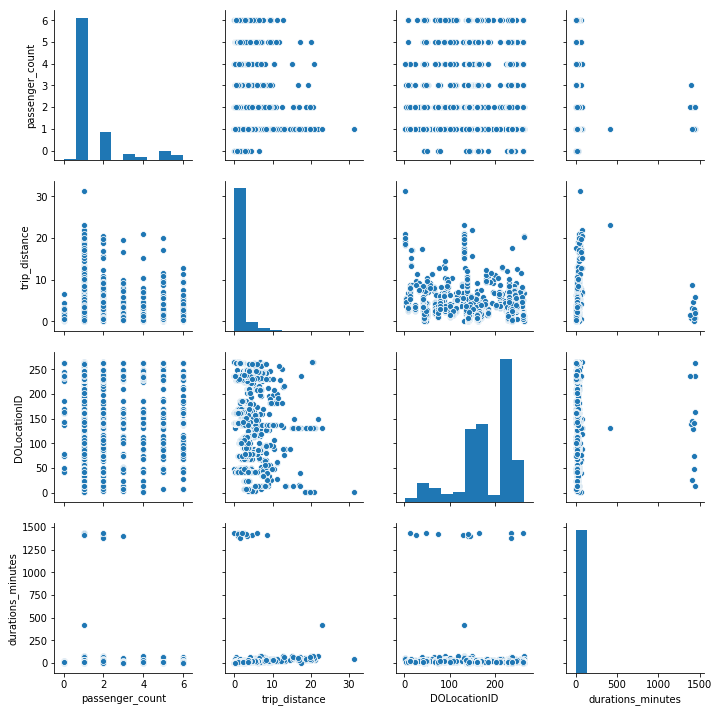

In [8]:
sns.pairplot(explore);

We see some really long rides are making it difficult to see patterns in our data. We don't get to control the test set, but we don't want these outliers to dictate the training portion.

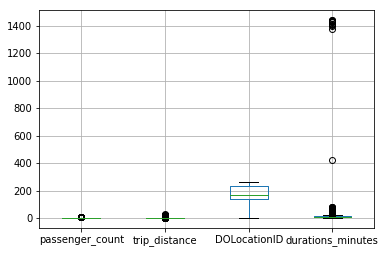

In [9]:
explore.boxplot()

What fractions of trips are we throwing away if we eliminate all rides > 200 minutes?

In [10]:
(explore['durations_minutes'] > 200).sum()/len(explore)

0.0013

This is 0.1%, which I am okay with throwing out.

In [11]:
explore = explore[explore['durations_minutes'] < 200]

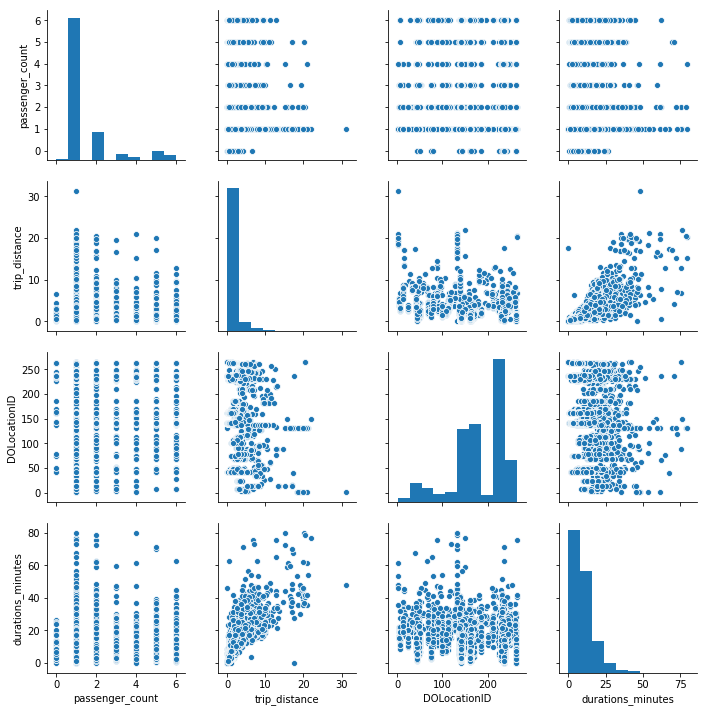

In [12]:
sns.pairplot(explore)

We also need to look at time of day. We know (from yesterday) that day_of_week and hour seemed important.

In [13]:
explore['hour'] = explore['tpep_pickup_datetime'].dt.hour
explore['day_of_week'] = explore['tpep_pickup_datetime'].dt.dayofweek
explore['is_weekend'] = (explore['day_of_week'] > 4)

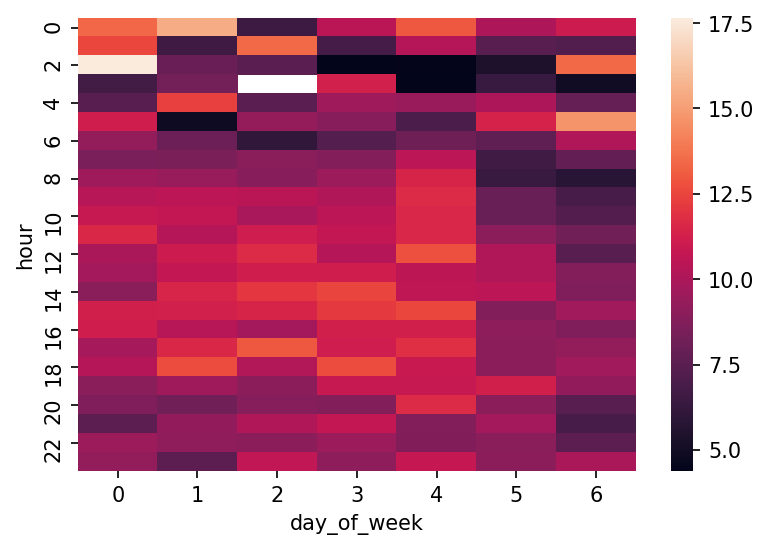

In [14]:
timetable = explore.groupby(['day_of_week', 'hour'])['durations_minutes'].mean().reset_index()

plt.figure(dpi=150)
sns.heatmap(timetable.pivot(index='hour', columns='day_of_week', values='durations_minutes'))


We also discussed that:
* day_of_week should be categorical
* DOLocationID should be categorical

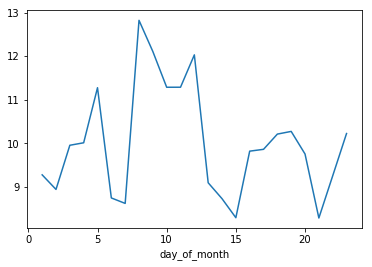

In [15]:
## Let's look at the trend over time
explore['day_of_month'] = explore['tpep_pickup_datetime'].dt.day
explore.groupby('day_of_month')['durations_minutes'].mean().plot();

## Experiment

Before making a fully formed pipeline, I like to try making a model from my data. I am going to make the same features that I made during my EDA, and then I am going to try fitting a `RandomForestRegressor`, as this is a reasonably robust model.

In [16]:
if 'tpep_pickup_datetime' in X_train.columns:
    X_train['hour'] = X_train['tpep_pickup_datetime'].dt.hour.astype(float)
    X_train['day_of_week'] = X_train['tpep_pickup_datetime'].dt.dayofweek
    X_train['is_weekend'] = (X_train['day_of_week'] > 4).astype(float)
    X_train.drop('tpep_pickup_datetime', axis=1, inplace=True)

In [17]:
def to_float(X):
    return X.astype(float)

log_transformer = FunctionTransformer(np.log1p, validate=False)
float_transformer = FunctionTransformer(to_float, validate=False)

preprocess = make_column_transformer(
    (log_transformer, ['trip_distance']),
    (OneHotEncoder(handle_unknown='ignore'), ['day_of_week']),
    (StandardScaler(), ['trip_distance', 'passenger_count', 'hour']),
)

prepare_pipeline = Pipeline(
    [
    ('conversion', float_transformer),
    ('make_columns', preprocess)
    ]
)

In [18]:
prepare_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('conversion', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function to_float at 0x1a14e3cf28>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=False)), ('make_columns', ColumnTransformer(n_jobs=None, remaind...dScaler(copy=True, with_mean=True, with_std=True), ['trip_distance', 'passenger_count', 'hour'])]))])

In [19]:
new_df = prepare_pipeline.transform(X_train)

In [20]:
new_df.shape

(255050, 11)

In [21]:
features = ['passenger_count', 'trip_distance', 'DOLocationID', 'hour', 'day_of_week', 'is_weekend']
X_train.shape

(255050, 6)

In [22]:
X_train.head(6)

,passenger_count,trip_distance,DOLocationID,hour,day_of_week,is_weekend
0,2,1.13,161,0.0,0,0.0
1,1,3.00,224,0.0,0,0.0
2,1,1.10,162,0.0,0,0.0
3,1,0.93,237,0.0,0,0.0
4,1,3.40,224,0.0,0,0.0
5,2,1.50,229,0.0,0,0.0


In [23]:
new_features=[
    'log_distance',
    'is_mon', 'is_tue', 'is_wed', 'is_thu', 'is_fri', 'is_sat',
    'is_weekend',
    'trip_distance', 'passenger_count', 'hour'
]

In [24]:
kf = KFold(n_splits=3, shuffle=True, random_state=24601)

In [25]:
new_df = pd.DataFrame(new_df, columns=new_features)
new_df.head()

,log_distance,is_mon,is_tue,is_wed,is_thu,is_fri,is_sat,is_weekend,trip_distance,passenger_count,hour
0,0.756122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.289258,0.326066,-2.887043
1,1.386294,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.685923,-0.472175,-2.887043
2,0.741937,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.304903,-0.472175,-2.887043
3,0.657520,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.393555,-0.472175,-2.887043
4,1.481605,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.894518,-0.472175,-2.887043


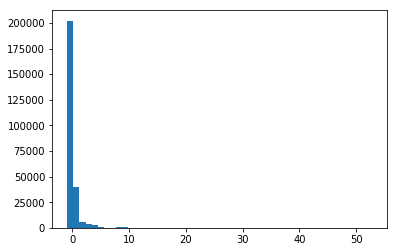

In [26]:
plt.hist(new_df['trip_distance'],bins=50);

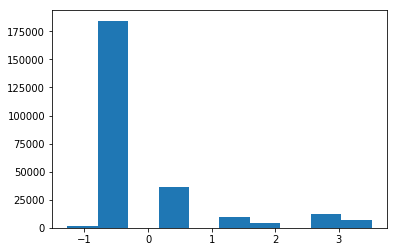

In [27]:
plt.hist(new_df['passenger_count'],bins=10);

In [28]:
rf = RandomForestRegressor(n_estimators=400, max_depth=4, random_state=52)
grid_explore = GridSearchCV(rf, param_grid={}, return_train_score=True, cv=kf)

In [29]:
grid_explore.fit(new_df, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=24601, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=False, random_state=52, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [30]:
grid_explore.best_score_

0.01599053487463723

In [31]:
grid_explore.cv_results_

{'mean_fit_time': array([36.67416032]),
 'mean_score_time': array([0.78516197]),
 'mean_test_score': array([0.01599053]),
 'mean_train_score': array([0.02252521]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.0163658]),
 'split0_train_score': array([0.02322206]),
 'split1_test_score': array([0.01487684]),
 'split1_train_score': array([0.02233514]),
 'split2_test_score': array([0.01672898]),
 'split2_train_score': array([0.02201844]),
 'std_fit_time': array([0.20524363]),
 'std_score_time': array([0.02024027]),
 'std_test_score': array([0.00080134]),
 'std_train_score': array([0.00050943])}

In [32]:
y_predict = grid_explore.predict(new_df)

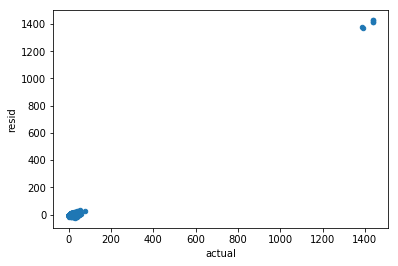

In [33]:
result_df = pd.DataFrame({
    'actual': y_train,
    'resid' : y_train - y_predict
})

result_df.sample(5000).plot.scatter(x='actual', y='resid')

Ah hah! The problem is that I have those outliers, and they are skewing everything. Let's see how the model improves if I eliminate those

In [34]:
# eliminate the outliers
keep_index = (y_train < 200)
y_train = y_train[keep_index]
X_train = X_train[keep_index]

In [35]:
prepare_pipeline.fit(X_train)
new_df = prepare_pipeline.transform(X_train)

In [36]:
new_df = pd.DataFrame(new_df, columns=new_features)
new_df.head()

,log_distance,is_mon,is_tue,is_wed,is_thu,is_fri,is_sat,is_weekend,trip_distance,passenger_count,hour
0,0.756122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.289091,0.326538,-2.88685
1,1.386294,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.687169,-0.471994,-2.88685
2,0.741937,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.304753,-0.471994,-2.88685
3,0.657520,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.393504,-0.471994,-2.88685
4,1.481605,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.895994,-0.471994,-2.88685


In [37]:
rf = RandomForestRegressor(n_estimators=400, max_depth=4, random_state=52)
grid_explore = GridSearchCV(rf, param_grid={}, return_train_score=True, cv=kf)

In [38]:
grid_explore.fit(new_df, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=24601, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=False, random_state=52, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [39]:
grid_explore.best_score_

0.6924717521205594

That looks a *lot* better! Let's look at the residual plot, and just check nothing is obviously wrong there.

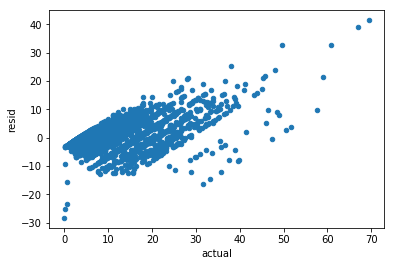

In [40]:
y_predict = grid_explore.predict(new_df)

result_df = pd.DataFrame({
    'actual': y_train,
    'resid' : y_train - y_predict
})

result_df.sample(5000).plot.scatter(x='actual', y='resid')

This suggests I might get a better result if I look at the log transform of the duration minutes instead.

(0, 50)

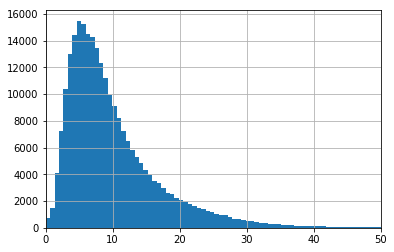

In [41]:
y_train.hist(bins=300)
plt.xlim(0,50)

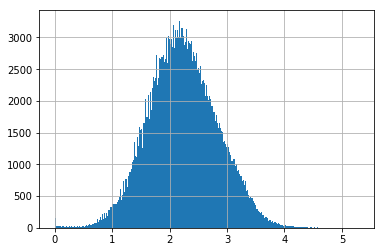

In [42]:
np.log1p(y_train).hist(bins=300)

## Feature engineering


Let's one-hot encode our features. Previously we used `pd.get_dummies`, but there is a nicer way that fits into a pipeline (this deals with new categories that only show up in the test data, for example)

In [43]:
if 'tpep_pickup_datetime' in X_train.columns:
    X_train['hour'] = X_train['tpep_pickup_datetime'].dt.hour.astype(float)
    X_train['day_of_week'] = X_train['tpep_pickup_datetime'].dt.dayofweek
    X_train['is_weekend'] = (X_train['day_of_week'] > 4).astype(float)
    
    # This will get used later, when we realize something went wrong
    X_train_day_of_year = X_train['tpep_pickup_datetime'].dt.day
    
    # Drop the extremes
    keep_index = (y_train < 1000)
    X_train = X_train[keep_index]
    y_train = y_train[keep_index]
    
    X_train.drop('DOLocationID', axis=1)
    X_train.drop('tpep_pickup_datetime', axis=1, inplace=True)
    
    
def to_float(X):
    return X.astype(float)

log_transformer = FunctionTransformer(np.log1p, validate=False)
float_transformer = FunctionTransformer(to_float, validate=False)

preprocess = make_column_transformer(
    (log_transformer, ['trip_distance']),
    (OneHotEncoder(handle_unknown='ignore'), ['day_of_week']),
    (StandardScaler(), ['trip_distance', 'passenger_count', 'hour']),
)

steps_rf = [
    ('conversion', float_transformer),
    ('make_columns', preprocess),
    ('model_rf', RandomForestRegressor())
]

steps_grad_boost = [
    ('conversion', float_transformer),
    ('make_columns', preprocess),
    ('model_gb', GradientBoostingRegressor())
]

steps_svm = [
    ('conversion', float_transformer),
    ('make_columns', preprocess),
    ('kernel', Nystroem(kernel='rbf', gamma=0.5, random_state=33)),
    ('svm_approx', SGDRegressor(max_iter=None, tol=1e-3, random_state=57))
]

In [44]:
estimator_rf = Pipeline(steps_rf)
estimator_gb = Pipeline(steps_grad_boost)
estimator_svm = Pipeline(steps_svm)

## Make some helper functions

In [45]:
def plot_residual(fitted_model, X, y, figsize=(10,6)):
    y_predict = fitted_model.predict(X)
    residual = y - y_predict
    
    plt.figure(figsize=figsize)
    plt.plot(y, residual, 'o', alpha=0.05)
    plt.xlabel('Actual results')
    plt.ylabel('Residual')
    
def plot_residual_contour(fitted_model, X, y, size=10, longest_ride=60):
    # predict on _all_ points
    y_predict = fitted_model.predict(X)
    residual = y - y_predict
    
    # Let's trim down the model before plotting
    if longest_ride:
        keep = (y < longest_ride)
        y = y[keep]
        residual = residual[keep]
    sns.jointplot(y, residual, kind='kde', height=size)
    plt.xlabel('Actual results')
    plt.ylabel('Residual')

## Do cross validation on model

We are now in a position where we can start going through the different pipelines.

### Regression pipeline

In [46]:
params_rf = {
    'model_rf__max_depth': [3, 6, 10],
    'model_rf__n_estimators': [80, 100, 200]
}

grid_rf = GridSearchCV(estimator_rf, param_grid=params_rf, cv=3, return_train_score=True)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('conversion', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function to_float at 0x1a110730d0>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=False)), ('make_columns', ColumnTransformer(n_jobs=None, remaind...s='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'model_rf__max_depth': [3, 6, 10], 'model_rf__n_estimators': [80, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [47]:
grid_rf.best_params_, grid_rf.best_score_

({'model_rf__max_depth': 10, 'model_rf__n_estimators': 200},
 0.7410210771069856)

Our intuition tells us that we should have better performance as we add more trees. What happened here?

First let's grab the number of trees from our `grid_rf.cv_results`:

In [48]:
num_trees = grid_rf.cv_results_['param_model_rf__n_estimators'].data
num_trees

array([80, 100, 200, 80, 100, 200, 80, 100, 200], dtype=object)

Let's use this and the score to make a plot, and help us diagnose what the effect of adding more trees is

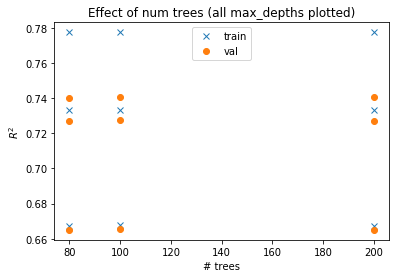

In [49]:
train = grid_rf.cv_results_['mean_train_score']
val = grid_rf.cv_results_['mean_test_score']

plt.plot(num_trees, train, 'x', label='train')
plt.plot(num_trees, val, 'o', label='val')

plt.legend()
plt.title('Effect of num trees (all max_depths plotted)')
plt.xlabel('# trees')
plt.ylabel('$R^2$');

We can see that change the max depth seems to have a big effect, but that the number of estimators isn't really changing anything meaningful. Let's look at the max depth in more detail:

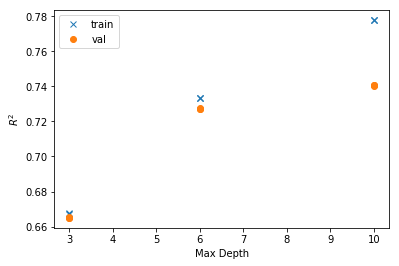

In [50]:
depth = grid_rf.cv_results_['param_model_rf__max_depth'].data

plt.plot(depth, train, 'x', label='train')
plt.plot(depth, val, 'o', label='val')
plt.xlabel('Max Depth')
plt.ylabel('$R^2$')
plt.legend();

We can see the training score is increasing _much_ faster than the testing score. I would be tempted to look at a few more sizes in the vicinity of 8 - 14 for the max depth now. I would keep the `n_estimators` at 80, as increasing it doesn't seem to improve things.

In [51]:
## Iterate! Random forest model
params_rf = {
    'model_rf__max_depth': range(8,15),
    'model_rf__n_estimators': [80]
}

grid_rf = GridSearchCV(estimator_rf, param_grid=params_rf, cv=3, return_train_score=True)

grid_rf.fit(X_train, y_train)
grid_rf.best_score_

0.7404464913260337

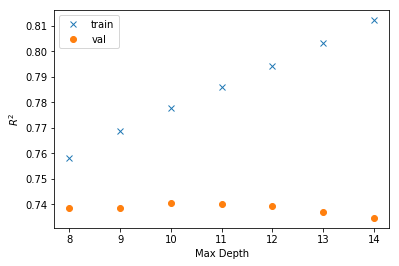

In [52]:
depth = grid_rf.cv_results_['param_model_rf__max_depth'].data
train = grid_rf.cv_results_['mean_train_score']
val = grid_rf.cv_results_['mean_test_score']

plt.plot(depth, train, 'x', label='train')
plt.plot(depth, val, 'o', label='val')
plt.xlabel('Max Depth')
plt.ylabel('$R^2$')
plt.legend();

A depth of 10 really does seem to work best. Let's check best params, and do a residual plot just to be sure.

In [53]:
grid_rf.best_params_

{'model_rf__max_depth': 10, 'model_rf__n_estimators': 80}

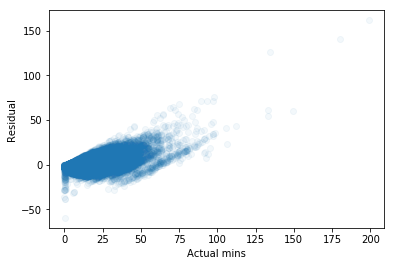

In [54]:
y_predict = grid_rf.predict(X_train)
plt.plot(y_train, y_train - y_predict, 'o', alpha=0.05)
plt.xlabel('Actual mins')
plt.ylabel('Residual');

### Gradient Booster

In [55]:
params_gb = {
    'model_gb__max_depth': [1, 2, 3, 6, 8],
    'model_gb__n_estimators': [20, 30, 50, 80]
}

grid_gb = GridSearchCV(estimator_gb, param_grid=params_gb, cv=3, iid=False)

# limit this for time
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('conversion', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function to_float at 0x1a110730d0>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=False)), ('make_columns', ColumnTransformer(n_jobs=None, remaind...one, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'model_gb__max_depth': [1, 2, 3, 6, 8], 'model_gb__n_estimators': [20, 30, 50, 80]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
grid_gb.best_params_, grid_gb.best_score_

({'model_gb__max_depth': 6, 'model_gb__n_estimators': 50}, 0.7458385713586494)

Looks pretty good! Note that I had changed the `params_gb` multiple times at this point - this wasn't my first guess!

This score is currently pretty competitive with the score I have from the random forest model. Just to be on the safe side, I'll make a plot of the residuals.

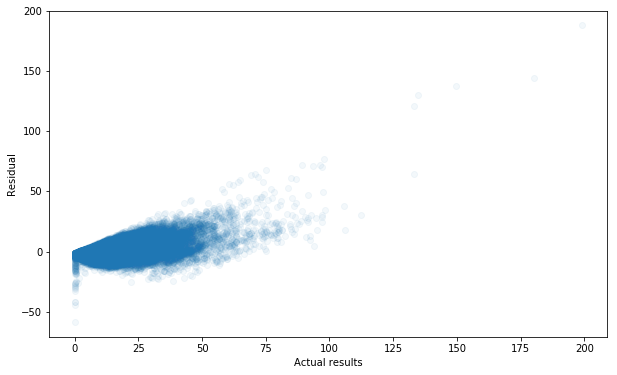

In [57]:
plot_residual(grid_gb, X_train, y_train)

### SVM

In [58]:
params_svm = {
    'kernel__gamma': [0.01, 0.1, 0.3, .5, 1, 2, 10]
}

grid_svm = GridSearchCV(estimator_svm, param_grid=params_svm, cv=3)

grid_svm.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('conversion', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function to_float at 0x1a110730d0>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=False)), ('make_columns', ColumnTransformer(n_jobs=None, remaind...om_state=57, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel__gamma': [0.01, 0.1, 0.3, 0.5, 1, 2, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
grid_svm.best_params_, grid_svm.best_score_

({'kernel__gamma': 0.1}, 0.7181897544832496)

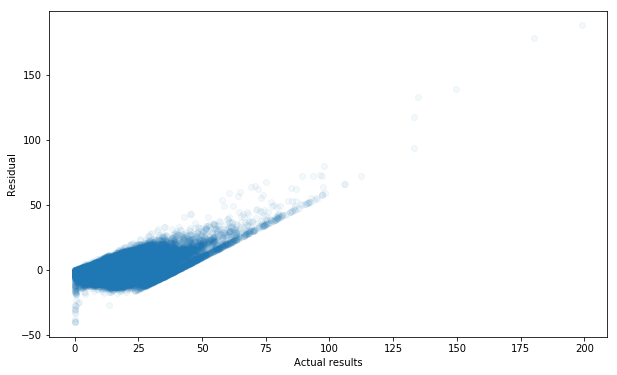

In [60]:
plot_residual(grid_svm, X_train, y_train)

## Iterate?

At this point, we would look at the different scores (particularly the best scores). We might also decide to look at some diagnostic plots (particularly what the residual vs predicted scores look like to see if we have particular errors). 

We can also try subsetting and averaging absolute errors against different groups (e.g. day of week, time of day) to see if there are patterns that our model is consistently missing.



We also seem to have some negative time predictions. We might investigate modeling on trying to find the _log(duration)_, even if the metric we are expected to report on is $R^2$ as measured in duration.

We will expect to get a worse $R^2$ (measured in linear space), but we will do better on short trips, which might be more relevant from a buisness perspective.

Changes I would consider at this point:

- Targeting $\log(\text{duration})$
- Adding in the `DOLocationID` as a categorical variable, or
- Adding in the most popular 20 `DOLocationID` as categorical variables + other
- Refining my grid searches

If I was going to dig into the $R^2$ plot, I might consider looking at a jointplot from seaborn to help with the overplotting issue I am running into. 

### Note:

There should be a minimum $R^2$ set needed for this solution to be useful for the business problem. If there isn't, then you should probably pick a different metric that does apply to your metric.

This will help me decide when I can stop digging into the data and looking for more patterns.

## Compare and decide

Our results were

In [61]:
grid_order = [grid_rf, grid_gb, grid_svm]

results_frame = pd.DataFrame({
    'params': [grid.best_params_ for grid in grid_order],
    'score': [grid.best_score_ for grid in grid_order],
})
results_frame.sort_values(by='score', ascending=False)

,params,score
1,"{'model_gb__max_depth': 6, 'model_gb__n_estima...",0.745839
0,"{'model_rf__max_depth': 10, 'model_rf__n_estim...",0.740446
2,{'kernel__gamma': 0.1},0.718190


Even though the GradientBoosted score is a little better, I would probably go with the random forest model, because it is safe from overfiting (at least from having too many trees).

It is also worthwhile to check that the top two competing methods somewhat agree on which features are the most important (if they do this gives us confidence that our methods are somewhat stable).

In [79]:
rf_importances = grid_rf.best_estimator_.named_steps['model_rf'].feature_importances_
gb_importances = grid_gb.best_estimator_.named_steps['model_gb'].feature_importances_

sorted(zip(rf_importances, new_features), reverse=True)

[(0.4714266101142264, 'trip_distance'),
 (0.4195262800498935, 'log_distance'),
 (0.07348377446948996, 'hour'),
 (0.014427390641367952, 'is_weekend'),
 (0.010103761859405229, 'is_sat'),
 (0.004462548044672595, 'is_mon'),
 (0.002840900826369703, 'passenger_count'),
 (0.0014771637137575022, 'is_fri'),
 (0.0010666915009280248, 'is_thu'),
 (0.0007269819028813258, 'is_tue'),
 (0.00045789687700794517, 'is_wed')]

In [80]:
sorted(zip(gb_importances, new_features), reverse=True)

[(0.47833417210360546, 'trip_distance'),
 (0.41024360962552014, 'log_distance'),
 (0.07694689224990084, 'hour'),
 (0.014553635738418443, 'is_weekend'),
 (0.007613484755093057, 'is_sat'),
 (0.004267099786582971, 'is_fri'),
 (0.00290678522333932, 'is_mon'),
 (0.002126774139788077, 'is_thu'),
 (0.0014944167738967866, 'is_wed'),
 (0.0008686377563392417, 'passenger_count'),
 (0.0006444918475158194, 'is_tue')]

There is good qualitative agreement! The order changes down the bottom, but we don't care as much about ordering of features that are starting to look like noise.

#### Room to grow?

I might also care about the ability of each model to respond to collecting more data, so it might be interesting to look at a learning curve for the different models. At the moment, I am not seriously considering the SVM, so I probably wouldn't actually bother making its learning curve. I have only included it here for comparison purposes.

**Hint:**

I have set the training sizes myself, and obtained the scores in a function. One advantage of setting the training scores myself is that I can run some small training sizes first (which is a lot quicker) to make sure I have done my calculations correctly. (e.g. in the first version of this, I accidentally made both the `mean_train_score` and `mean_test_score` average the training scores!

In [95]:
def model_learning_curve(estimator, cv=3, X=X_train, y=y_train, 
                         train_sizes=[500, 1000, 5000, 10000]):
    # Throw away the train sizes, because I am putting that in by hand
    _, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv,
                                                 train_sizes=train_sizes)
    # average over the folds
    mean_train_score = train_scores.mean(axis=1)
    mean_val_score = val_scores.mean(axis=1)
    
    return mean_train_score, mean_val_score    

In [104]:
# Stopping early simply due to time constraints
# The time isn't terrible (~5 mins) so I would 
# return and add in 0.5, 1.0 as well
train_sizes = [0.01, 0.05, 0.1, 0.3]

rf_train_score, rf_val_score = model_learning_curve(grid_rf, cv=3, train_sizes=train_sizes)

In [105]:
gb_train_score, gb_val_score = model_learning_curve(grid_gb, cv=3, train_sizes=train_sizes)

In [106]:
import warnings

with warnings.catch_warnings(record=True):
    svm_train_score, svm_val_score = model_learning_curve(grid_svm, cv=3, train_sizes=train_sizes)

In [107]:
svm_train_score, svm_val_score

(array([0.69072521, 0.73387617, 0.73986642, 0.75035627]),
 array([-0.3092407 ,  0.52151583,  0.60878073,  0.69850925]))

Text(0,0.5,'$R^2$')

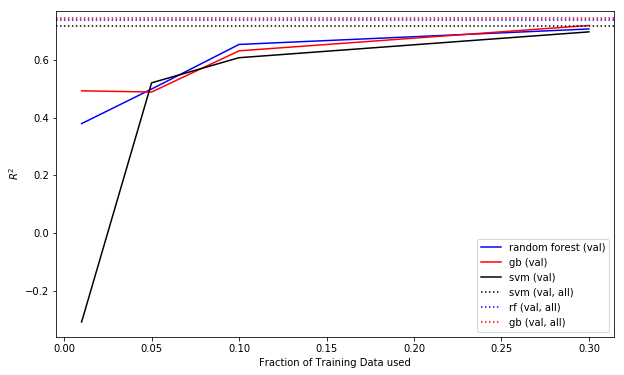

In [134]:
plt.figure(figsize=(10, 6))

#plt.plot(train_sizes, rf_train_score, 'b--', label='random forest (train)')
plt.plot(train_sizes, rf_val_score, 'b-', label='random forest (val)')

#plt.plot(train_sizes, gb_train_score, 'r--', label='gb (train)')
plt.plot(train_sizes, gb_val_score, 'r-', label='gb (val)')

#plt.plot(train_sizes, svm_train_score, 'k--', label='svm (train)')
plt.plot(train_sizes, svm_val_score, 'k-', label='svm (val)')

plt.gca().axhline(grid_svm.best_score_, linestyle=':', color='k', label='svm (val, all)')
plt.gca().axhline(grid_rf.best_score_, linestyle=':', color='b', label='rf (val, all)')
plt.gca().axhline(grid_gb.best_score_, linestyle=':', color='r', label='gb (val, all)')

plt.legend()
plt.xlabel('Fraction of Training Data used')
plt.ylabel('$R^2$')

## Final evaluation

Now it is time to see how well our model does on new data. Note we still have to make the columns we made for the training data.

In [109]:
if 'tpep_pickup_datetime' in X_test.columns:
    X_test['hour'] = X_test['tpep_pickup_datetime'].dt.hour.astype(float)
    X_test['day_of_week'] = X_test['tpep_pickup_datetime'].dt.dayofweek
    X_test['is_weekend'] = (X_test['day_of_week'] > 4).astype(float)
    
    X_test.drop('DOLocationID', axis=1)
    X_test.drop('tpep_pickup_datetime', axis=1, inplace=True)

In [110]:
grid_rf.score(X_test, y_test)

0.5145119251126109

Ouch! 

Are we being punished for a few (probably) faulty data points where the meter is left running? Let's eliminate the offending points, and rerun the metric.

In general, you want to be sure these are spurious data points. If they are genuine outliers, and $R^2$ is the appopriate metric, you will be making _huge_ errors.

In [111]:
# Is this score "true" overfitting, or are there some clearly stupid points in the test
# set?

keep = (y_test < 1000)
X_test = X_test[keep]
y_test = y_test[keep]

In [112]:
grid_rf.score(X_test, y_test)

0.5145119251126109

Let's plot the residuals (using points and the contour plot)

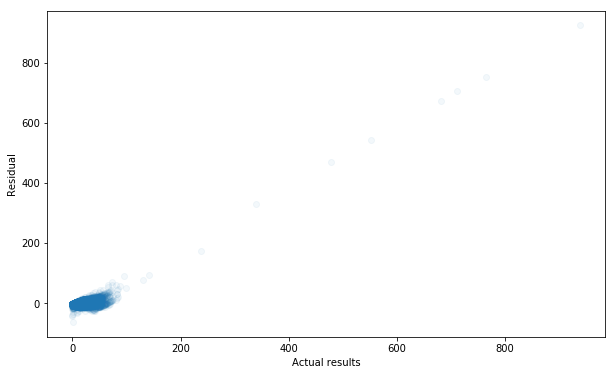

In [113]:
plot_residual(grid_rf, X_test, y_test)

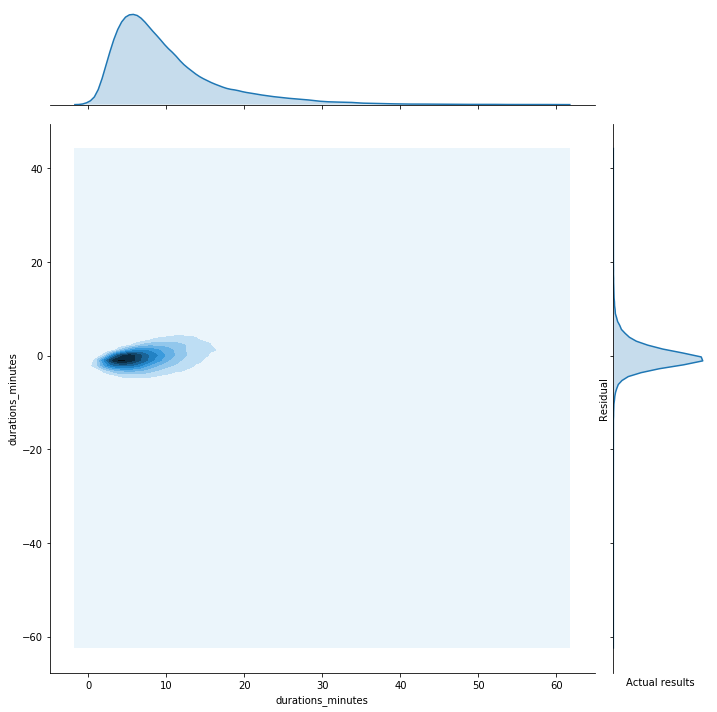

In [114]:
plot_residual_contour(grid_rf, X_test, y_test)

Why have we done so poorly? The $R^2$ isn't terrible (we have explained over half the variance) but it is a lot lower than the 0.75 we were expecting from our hold-out set.

There are a couple of possiblities:

1. Maybe the last week of January really comes from a different distribution. It isn't clear why this would be the case, but if you (for example) tried to use all of June's data to predict the first week of July, the 4th of July is probably different enough that you won't generalize well. Short of getting more training data from previous July weeks, there isn't really anything you can do about this.

2. There might be data leakage between teh validation and training sets, making the scores artifically high.

The answer probably lies in _data leakage_. We are trying to predict the last week of January, and held that out from the start. When doing our `KFold` validation, however, information about a particular date and hour can be in both a training fold and a validation fold. Since traffic at the same time is highly correlated, my model is able to pick up information it shouldn't have access to about the validation score, lowering the $R^2$.

#### Fixing the problem

We can solve this by making a day of month column and using that in  [`GroupKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html), and using that to generate the KFolds instead. See code below. This will ensure that all the rows for a particular day are in the same fold, so we cannot have information leaking between test and training folds. The code for this is

```python
from sklearn.model_selection import GroupKFold

# When making the grid search, pass in the "group aware" KFolds object
kf = GroupKFold(n_splits=3)

grid_example = GridSearchCV(RandomForest(), param_grid={}, cv=kf)

# When fitting, pass in the day_of_year as the groups to keep together in 
# the same fold.
grid_rf.fit(X_train, y_train, groups=X_train_day_of_year)
```

Ideally, you would get some different data to do the analysis (now that you have used the test set). In this case, it would probably be okay to rerun and redo the analysis. While a little information will be leaking, we have a large dataset, so we probably have enough data that this leakage won't have a huge effect. We are also fixing a problem in our sampling technique; we are not using the information about poor performance to tell us how to adjust our model directly. Instead we are saying there was a lack of validity in the previous procedure we have uncovered, so we should fix the procedural issue (code above) and then start the process over.

While it is never great to uncover a leakage error, at least we diagonsed it on the test data, before deploying the model and having it cost us real money. Note if we had just done a test train split at the beginning, we would have the same leakage problem, and the test score would be similar to the CV scores. It is only when we deployed the model that we would uncover our sampling error.

**This is a step we will skip, as it would involve re-running all the notebook**

## Finally, retrain the model on "all" the data

We know that the extreme outliers tend to skew our data in training, so we would still drop the outliers. But to make our model for production, we would then refit on all the remaining data

In [115]:
final_taxi_df = taxi_df[taxi_df['durations_minutes'] < 1000].copy()

if 'tpep_pickup_datetime' in final_taxi_df.columns:
    final_taxi_df['hour'] = final_taxi_df['tpep_pickup_datetime'].dt.hour.astype(float)
    final_taxi_df['day_of_week'] = final_taxi_df['tpep_pickup_datetime'].dt.dayofweek
    final_taxi_df['is_weekend'] = (final_taxi_df['day_of_week'] > 4).astype(float)
        
    final_taxi_df.drop('DOLocationID', axis=1)
    final_taxi_df.drop('tpep_pickup_datetime', axis=1, inplace=True)

X_final = final_taxi_df.drop('durations_minutes', axis=1)
y_final = final_taxi_df['durations_minutes']

In [116]:
# Use the best existing parameters
final_grid = {
    key:[value] for key, value in grid_rf.best_params_.items()
}

final_model = GridSearchCV(estimator_rf, param_grid=final_grid, cv=3)

In [117]:
final_model.fit(X_final, y_final)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('conversion', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function to_float at 0x1a110730d0>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=False)), ('make_columns', ColumnTransformer(n_jobs=None, remaind...s='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'model_rf__max_depth': [10], 'model_rf__n_estimators': [80]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [118]:
# This score is on the data that we trained on, it is optimistic!
final_model.best_score_

0.5842379297854965

We are done!